# "FashionMNIST with PyTorch & fastAI"
> "[Part 2] Solving FashionMNIST for Google Code-In for Julia"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [pytorch, ml, gci19]
- image: images/fmnist.png
- hide: false
- search_exclude: false

## Task Statement :
Fashion MNIST is a good way to introduce the concept of autoenoders and for classification tasks. Write an efficient Fashion MNIST implementation using Flux and benchmark it against equivalent implementations in TensorFlow and PyTorch. A good extension might be to have it run smoothly on GPUs too. The FashionMNIST dataset can be easily obtained and unpackaged into ready-to-use Julia data types with the help of MLDatasets.jl. A working example of using Flux for classification of handwritten digits from the MNIST dataset can be found here, for students who are already familiar with basic image detection techniques and want to hit the ground running. Flux's documentation can be found here.

I am going to use a pretrained (CNN) called resnet34. (Only thing I understood after watching first three fastAI lectures that use this thing for image-classification tasks.) Hoping to understand more theory by reading this [article](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)

But honestly, I don't know the complete theory behind a CNN myself. I'm still trying to learn it from the lectures given in the Deep Learning Specialisation. I comletely know how to build simple multilayer perceptrons though and the theory behind them too. xD So I'll also try to make some of them on data-set.

Also the fastAI course followed a top-down approach to things, so yeah some concepts remain unclear but with reference to some of the image classification tasks we did in lectures 1 and 2 in the course, I was able to make this ! 

Julia code will be submitted seperately.

P.S: Special thanks to my mentor Kartikey Gupta for all his support and his [implementation](https://github.com/kraftpunk97/FashionMNIST-with-keras/blob/master/Fashion_MNIST_with_keras.ipynb) in Keras which provided me a path to write the notebook.

![FashionMNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import pandas as pd
fmnist_test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")
fmnist_train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#autoreload reloads modules automatically before entering the execution of code typed. It is beneficial to update matplotlib functions 
# everytime a cell is run.

In [3]:
from fastai.imports import *

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
print(os.listdir('../input/'))
PATH = "../input/"
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"
arch = resnet34
sz = 14

['fashionmnist']


## Data-Preprocessing

In [8]:
#collapse
fmnist_test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")
fmnist_train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")

#Shape of the data-sets. 
print(f'fmnist_train shape : {fmnist_train.shape}') #60,000 rows and 785 columns 
print(f'fmnist_test shape  : {fmnist_test.shape}')  #10,000 rows and 785 columns 
#Seeing some of the data distribution.
fmnist_train.head(7)

fmnist_train shape : (60000, 785)
fmnist_test shape  : (10000, 785)


label  pixel1  pixel2    ...     pixel782  pixel783  pixel784
0      2       0       0    ...            0         0         0
1      9       0       0    ...            0         0         0
2      6       0       0    ...            0         0         0
3      0       0       0    ...            0         0         0
4      3       0       0    ...            0         0         0
5      4       0       0    ...            0         0         0
6      4       0       0    ...            0         0         0

[7 rows x 785 columns]

* As from we can see, the first column depicts the label of the image which, from the official repository of the data-set are:<br>
**Labels**<br><br>

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [9]:
#I'll be now splitting 20% of the training data into validation data-set.
fmnist_valid = fmnist_train.sample(frac=0.2)
print(fmnist_valid.shape, '| Shape of Validation Set')
#Dropping the label's column since we would be predicting that.
fmnist_train = fmnist_train.drop(fmnist_valid.index)
print(fmnist_train.shape, '| Shape Training Set')

(12000, 785) | Shape of Validation Set
(48000, 785) | Shape Training Set


In [10]:
#Defining labels to predict 
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
#Getting the images as X (reshaping the images into 28x28) and labels (flattened) as y from the data-sets. (Changing the dimensions)
def split(data):
    '''returns a tuple (X, y) where
        X : the training inputs which is in (samples, height, width, channel) shape
        y : flattened (one-D) label vector
    '''
    y = data['label'].values.flatten()
    X = data.drop('label', axis=1).values
    X = X.reshape(X.shape[0], 28, 28)
    return (X,y)

X_train, y_train = split(fmnist_train)
X_valid, y_valid = split(fmnist_valid)
X_test, y_test   = split(fmnist_test)
print("Training Set Shape")
print(X_train.shape,'\n',y_train.shape)
print("Validation Set Shape")
print(X_valid.shape,'\n',y_valid.shape)
print("Test Set Shape")
print(X_test.shape,'\n',y_test.shape)

Training Set Shape
(48000, 28, 28) 
 (48000,)
Validation Set Shape
(12000, 28, 28) 
 (12000,)
Test Set Shape
(10000, 28, 28) 
 (10000,)


#### Some image processing tasks
Normalising image data [(learnt here)](https://en.wikipedia.org/wiki/Normalization_(image_processing) 
<code>Scaling the values of the individual pixels from 0->255 to 0->1 for reduced computational complexity.</code>
and adding image missing colour channels (don't understand this concept, saw this in many models on the same, will try to dig deep to learn more)

In [12]:
X_train = X_train.astype('float64') / 255
X_valid = X_valid.astype('float64') / 255
X_test = X_test.astype('float64') / 255

X_train = np.stack((X_train,) * 3, axis=-1)
X_valid = np.stack((X_valid,) * 3, axis=-1)
X_test  = np.stack((X_test,) * 3, axis=-1)

## Visualising a images.
using Matplotlib.

Text(0.5,1,'Pullover')

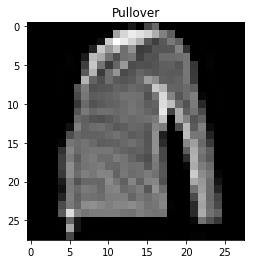

In [14]:
index = 42 #THE ANSWER TO LIFE, THE UNIVERSE AND EVERYTHING is a Pullover.
plt.imshow(X_train[index,], cmap='gray')
plt.title(labels[y_train[index]])

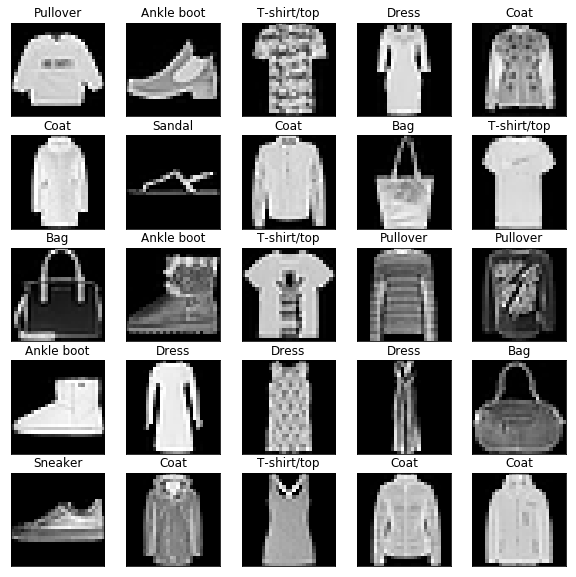

In [15]:
#Code inspiration from Kartikey's Keras implementation of the same
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap='gray')
  plt.title(labels[y_train[i]])
plt.show()

# Training the Model using pre-trained cnn (resnet34)
for 7 epochs

In [16]:
data = ImageClassifierData.from_arrays(PATH, trn=(X_train,y_train), classes=[0,1,2,3,4,5,6,7,8,9],val=(X_valid, y_valid), tfms=tfms_from_model(arch, 28), test=X_test)
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)
learn.fit(7e-3, 3, cycle_len=1, cycle_mult=2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 82135118.30it/s]


  0%|          | 0/750 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 157/157 [00:05<00:00, 31.20it/s]


epoch      trn_loss   val_loss   accuracy                    
    0      0.620987   0.512263   0.814333  
    1      0.578722   0.454397   0.832917                    
    2      0.53767    0.445395   0.83925                     
    3      0.525576   0.430741   0.841833                    
    4      0.486124   0.414247   0.8485                      
    5      0.494705   0.404226   0.853917                    
    6      0.456214   0.398733   0.855167                    



[0.3987334932486216, 0.8551666666666666]

We get around a **85.5517** which is good and not inflated like the 99% percent on MNIST data-sets.
From what I've scavenged from the web, the oneshot high accuracy of fast-ai library can be explained via:
1. TTA involves taking a series of different versions of the original image (for example cropping different areas, or changing the zoom) and passing them through the model. The average output is then calculated for the different versions and this is given as the final output score for the image.
2. Dropout combats overfitting and so would have proved crucial in winning on a relatively small dataset such at CIFAR10. Dropout is implemented automatically by fast ai when creating a learn object, though can be altered using the ps variable (not used here though)

In [20]:
log_predicns, _ = learn.TTA(is_test=True)
prods = np.exp(log_predicns)
prods = np.mean(prods, 0)
accuracy_np(prods, y_test)

0.8565

# 0.8565. -> 85.65 %
Some notes on accuracy vs precision in ML for my revision. <br>
\begin{equation}
accuracy=\frac{TruePositive+TrueNegative}{TruePositive+TrueNegative+FalsePositive+FlaseNegative}
\end{equation}

-PseudoCodeNerd 